In [1]:
import sys
sys.path.append('./packages')
sys.path.append('./wrappers')
from dataset_wrapper import initialise_dataset

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Modify to suit local machine
data_path = '../data/'

In [4]:
# Select what datatypes you would like to load from the dataset
# flair: Fluid-Attenuated Inversion Recovery. Highlights edema (swelling around tumor)
# t1: Standard T1-weighted scan. Good anatomical detail
# t1ce: T1-weighted with contrast enhancement. Shows areas where tumor enhances after injection of gadolinium
# t2: T2-weighted scan. Bright scan for fluids

modalities = ["flair", "t1", "t1ce", "t2"]

In [5]:
# DO NOT TOUCH
mod_dic = {}
for index, modality in enumerate(modalities):
    mod_dic[modality] = index

In [62]:
# This line should only every be ADDED to, and NOT subtracted from
# Import more functions if needed. Add them to transformations to apply them to data
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ToTensord,
    AdjustContrastd,
    HistogramNormalized,
    NormalizeIntensityd,
    Spacingd,
    Orientationd,
    CropForegroundd,
    ScaleIntensityRanged,
    CenterSpatialCropd,
)

In [107]:
# Pre-processing. Add as many pre-processing transformations as you wish. Must be from monai
# IMPORTANT: Do not remove transformations outside the "Personal Transformations" section
transformations = Compose([
    LoadImaged(keys=["image", "seg_mask"]),  # loads NIfTI files
    EnsureChannelFirstd(keys=["image"]),
    EnsureChannelFirstd(keys="seg_mask"),
    EnsureTyped(keys="seg_mask", dtype=np.uint8),

# ----------------- Personal Transformations ----------------- #

    Orientationd(keys=["image", "seg_mask"], axcodes="RAS"),
    Spacingd(
        keys=["image", "seg_mask"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest")
    ),
    CenterSpatialCropd(keys=["image", "seg_mask"], roi_size=(160, 192, 160)),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000, a_max=3000,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    HistogramNormalized(keys=["image"], num_bins=256),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    AdjustContrastd(keys=["image"], gamma=1.2),

# ------------------------------------------------------------ #

    ToTensord(keys=["image", "seg_mask"])  # convert both to torch tensors
])

In [108]:
# Initialises dataset that you can operate on
# Loads data DYNAMICALLY
dataset = initialise_dataset(data_path, modalities=modalities, transformations=transformations)

In [129]:
# Select Patient to observe
patient_id = 0
image, segmentation_mask = dataset.__getitem__(patient_id)
segmentation_mask = segmentation_mask[0]    # seg_mask has a channel dimension so need to remove it

In [142]:
# Select what MODALITY to visualise
modality = 'flair'
modality = mod_dic[modality]

image_selected_mod = image[modality,:,:,:]
image_selected_mod = image_selected_mod.squeeze(0)

In [143]:
slice_idx = 80  # pick any slice

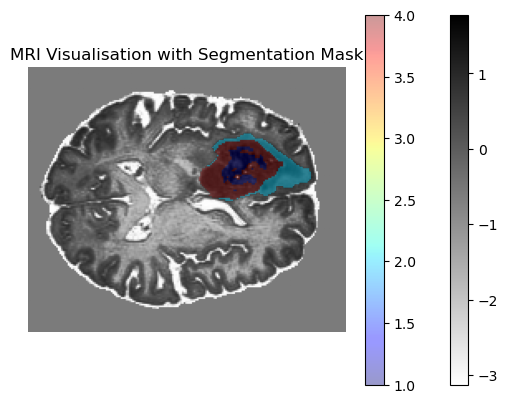

In [144]:
plt.imshow(image_selected_mod[:, :, slice_idx], cmap='gray_r')
#plt.imshow(image_selected_mod[:, :, slice_idx], cmap='gray')
plt.colorbar()
plt.imshow(np.ma.masked_where(segmentation_mask[:, :, slice_idx] == 0, segmentation_mask[:, :, slice_idx]), cmap='jet', alpha=0.4)
plt.colorbar()
plt.title("MRI Visualisation with Segmentation Mask")
plt.axis('off')
plt.show()